# DPR HTML Embedding

Dense Passage Retrieval (DPR) is a set of tools and models for state-of-the-art open-domain Q&A research. Open-domain question answering relies on efficient passage retrieval to select candidate contexts, where traditional sparse vector space models, such as TF-IDF or BM25, are the de facto method. In this work, we show that retrieval can be practically implemented using dense representations alone, where embeddings are learned from a small number of questions and passages by a simple **dual-encoder** framework.

[HuggingFace](https://huggingface.co/docs/transformers/model_doc/dpr), [Related paper](https://arxiv.org/abs/2004.04906)

## DPR Embedding Demo

**DPRContextEncoder** The bare DPRContextEncoder transformer outputting pooler outputs as context representations.
The DPR encoder outputs the `pooler_output` that corresponds to the context representation. Last layer hidden-state of the first token of the sequence (CLS token) further processed by a Linear layer. This output is to be used to embed contexts for nearest neighbors queries with questions embeddings.

**DPRQuestionEncoder** The bare DPRQuestionEncoder transformer outputting pooler outputs as question representations.
The DPR encoder outputs the `pooler_output` that corresponds to the question representation. Last layer hidden-state of the first token of the sequence (CLS token) further processed by a Linear layer. This output is to be used to embed questions for nearest neighbors queries with context embeddings.

## Build `DPREmbedding` Class
based on `langchain_core.embeddings` Module

In [1]:
import torch
import torch.nn.functional as F
from typing import Any, Dict, List

from transformers import DPRContextEncoder, DPRContextEncoderTokenizer, DPRQuestionEncoder, DPRQuestionEncoderTokenizer
from langchain_core.embeddings import Embeddings
from langchain_core.pydantic_v1 import BaseModel, root_validator

In [2]:
class DPREmbeddings(BaseModel, Embeddings):
    """DPR embedding models.

    To use, you should have the transformer python package installed

    Example:
        .. code-block:: python

            from transformers import DPRContextEncoder, DPRContextEncoderTokenizer, DPRQuestionEncoder, DPRQuestionEncoderTokenizer
            
            embeddings = DPREmbeddings()
    """
    ctx_tokenizer: Any #: : meta private:
    ctx_model: Any #: :meta private:
    
    q_tokenizer: Any #: : meta private:
    q_model: Any #: : meta private:

    @root_validator()
    def validate_environment(cls, values: Dict) -> Dict:
        """Validate that MarkupLMEmbedding is loaded."""

        try:
            from transformers import DPRContextEncoder, DPRContextEncoderTokenizer, DPRQuestionEncoder, DPRQuestionEncoderTokenizer
        except ImportError:
            raise ImportError(
                "Could not import MarkupLM library. "
                "Please install the transformer library to "
                "use this embedding model: pip install transformers"
            )
            
        ctx_tokenizer = DPRContextEncoderTokenizer.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")
        ctx_model = DPRContextEncoder.from_pretrained("facebook/dpr-ctx_encoder-single-nq-base")

        q_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained("facebook/dpr-question_encoder-single-nq-base")
        q_model = DPRQuestionEncoder.from_pretrained("facebook/dpr-question_encoder-single-nq-base")

        values["ctx_tokenizer"] = ctx_tokenizer
        values["ctx_model"] = ctx_model
        
        values["q_tokenizer"] = q_tokenizer
        values["q_model"] = q_model
        
        return values
    
    
    def embed_ctx(self, text: str) -> List[float]:
        """Embed a single HTML document using DPRContextEncoder.

        Args:
            text: The HTML text to embed.

        Returns:
            HTML Document embedding. 
        """
        
        input_ids = self.ctx_tokenizer(text, return_tensors="pt")["input_ids"]
        embedding = self.ctx_model(input_ids).pooler_output
    
        return embedding[0].tolist()


    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        """Embed a list of documents using DPR.

        Args:
            texts: The list of texts to embed.

        Returns:
            List of embeddings, one for each text.
        """

        embeddings = [self.embed_ctx(text) for text in texts]
        return embeddings

    def embed_query(self, text: str) -> List[float]:
        """Embed a query using DPRQuestionEncoder.

        Args:
            text: The text to embed.

        Returns:
            Embeddings for the text.
        """
        

        input_ids = self.q_tokenizer(text, return_tensors="pt")["input_ids"]
        embedding = self.q_model(input_ids).pooler_output
        
        return embedding[0].tolist()

In [3]:
# init embedding models
dpre = DPREmbeddings()

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.
Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification mod

## Langchain HTML Embedding
based on `DPREmbedding`

In [4]:
import os, glob
import matplotlib.pyplot as plt
from PIL import Image

from langchain.document_loaders import BSHTMLLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import CacheBackedEmbeddings
from langchain.vectorstores import FAISS
from langchain.storage import LocalFileStore

os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Load WebSRC Dataset

In [5]:
%%time

name_space = "auto-dpr"
# init Cache-Backed Embedder
lfs = LocalFileStore(os.path.join("./Embeddings", name_space))

cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    underlying_embeddings = dpre, 
    document_embedding_cache = lfs,
    namespace=name_space
)

# init splitter, reserved HTML tags
token_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500, chunk_overlap=50
)

# test on batch HTMLs, 519 files from auto vertical 
html_dir = f'../WebSRC/auto/*/processed_data/*.html'
docs = []

for fp in glob.glob(html_dir):
    loader = BSHTMLLoader(fp)
    doc = loader.load_and_split(token_splitter)
    docs.extend(doc)

len(docs)

CPU times: user 1.85 s, sys: 45.7 ms, total: 1.9 s
Wall time: 1.95 s


1171

In [6]:
docs[:3]

[Document(page_content='Interior       Front head room   38 "     Rear head room   38 "     Front shoulder room   58 "     Rear shoulder room   56 "     Front hip room   54 "     Rear hip room   48 "     Front leg room   41.0 "     Rear leg room   37.8 "     Luggage capacity   37.6 cu.ft.     Maximum cargo capacity   69.8 cu.ft.     Standard seating   5         Exterior       Length   180.9 "     Body width   73.0 "     Body height   67.2 "     Wheelbase   105.9 "     Ground clearance   8.6 "     Curb   3,380', metadata={'source': '../WebSRC/auto/03/processed_data/0300542.html', 'title': ''}),
 Document(page_content='"     Ground clearance   8.6 "     Curb   3,380 lbs.     Gross weight   4,610 lbs.           Fuel       Fuel tank capacity   14.5 gal.     EPA mileage estimates   28 City / 35 Hwy         Performance       Base engine size   2.5 liters     Base engine type   I-4     Horsepower   203 hp     Horsepower rpm   6,600     Torque   184 lb-ft.     Torque rpm   5,000     Payload   

In [7]:
%%time
# construct VectorDB
db = FAISS.from_documents(docs, cached_embedder)

CPU times: user 9min 20s, sys: 1min 16s, total: 10min 36s
Wall time: 1min 49s


> CPU times: user 9min 20s, sys: 1min 16s, total: 10min 36s, Wall time: 1min 49s

In [8]:
# display_images_with_scores, generated by ChatGPT
def display_images_with_scores(html_paths_scores, columns=3):
    """
    Given a list of tuples containing relative paths to HTML files and associated scores, this function finds
    the PNG images with the same base name in the same directory, loads them, and displays them in a grid layout
    in a Jupyter notebook. Each image is displayed with its filename and score in the title.

    :param html_paths_scores: List of tuples (html_path, score).
    :param columns: Number of columns in the grid.
    """
    # Determine the number of rows needed based on the number of images and desired columns
    rows = len(html_paths_scores) // columns + (len(html_paths_scores) % columns > 0)
    
    # Set up the figure and axes for the grid
    fig, axs = plt.subplots(rows, columns, figsize=(columns * 5, rows * 5))
    axs = axs.flatten()  # Flatten the axes array for easy iteration
    
    for idx, (html_path, score) in enumerate(html_paths_scores):
        # Extract the directory and the base file name from the HTML path
        base_dir, html_filename = os.path.split(html_path)
        base_filename = os.path.splitext(html_filename)[0]
        png_filename = f"{base_filename}.png"

        # Construct the path for the PNG file
        png_path = os.path.join(base_dir, png_filename)

        # Load and display the image with the filename and score in the title
        try:
            image = Image.open(png_path)
            axs[idx].imshow(image)
            title = f"{png_filename} - Score: {score}"
            axs[idx].set_title(title, fontsize=10)  # Show the image file name and score as the title
            axs[idx].axis('off')  # Turn off axis numbers
        except FileNotFoundError:
            axs[idx].set_title("File Not Found", fontsize=10)
            axs[idx].axis('off')
        except Exception as e:
            axs[idx].set_title(f"Error: {e}", fontsize=10)
            axs[idx].axis('off')

    # Hide any remaining empty subplots
    for ax in axs[len(html_paths_scores):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# def retrieval helper function, default top_k = 3
def html_retrieval_by_query(query, top_k=3):
    
    query_embedding = dpre.embed_query(query)
    docs = db.similarity_search_with_score_by_vector(query_embedding, k=top_k)
    display_images_with_scores([(doc[0].metadata['source'], doc[1]) for doc in docs])
    
    return

## Similarity search by vector

calculated by cosine similarity and sorted by the query relevance, scroll down to check the evaluation

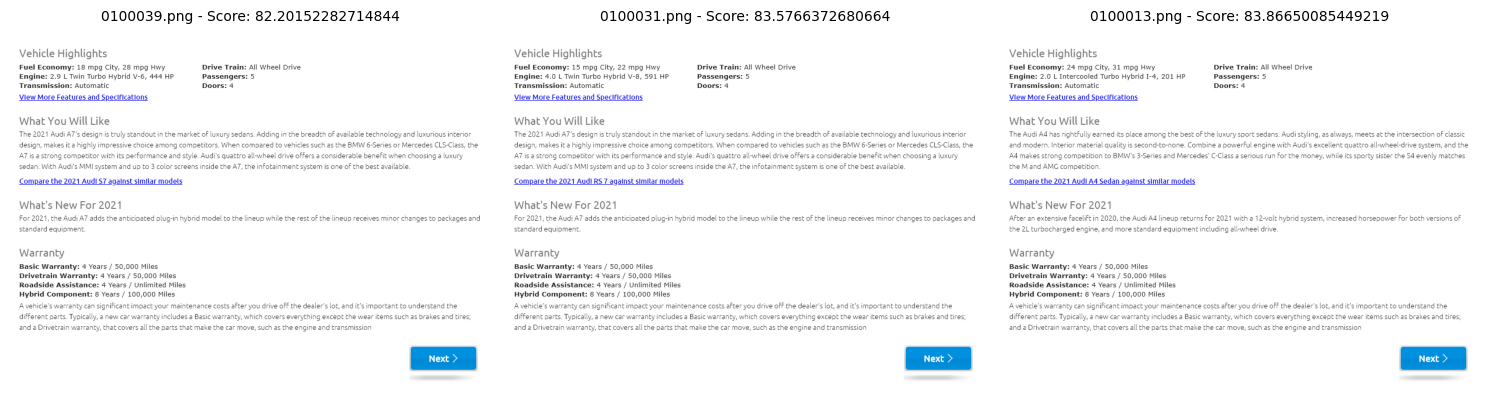

In [9]:
# 0900041
html_retrieval_by_query("How is the engine performance of the '2018 Maserati Ghibli'?") 

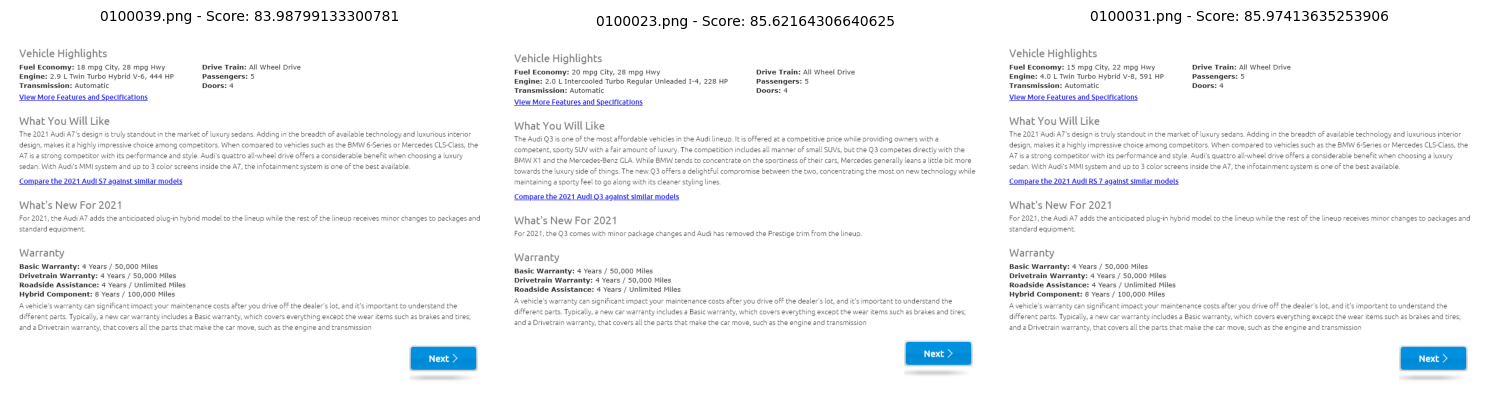

In [10]:
# 1200047
html_retrieval_by_query("The price MSRP of 'Kia Sportage'") 

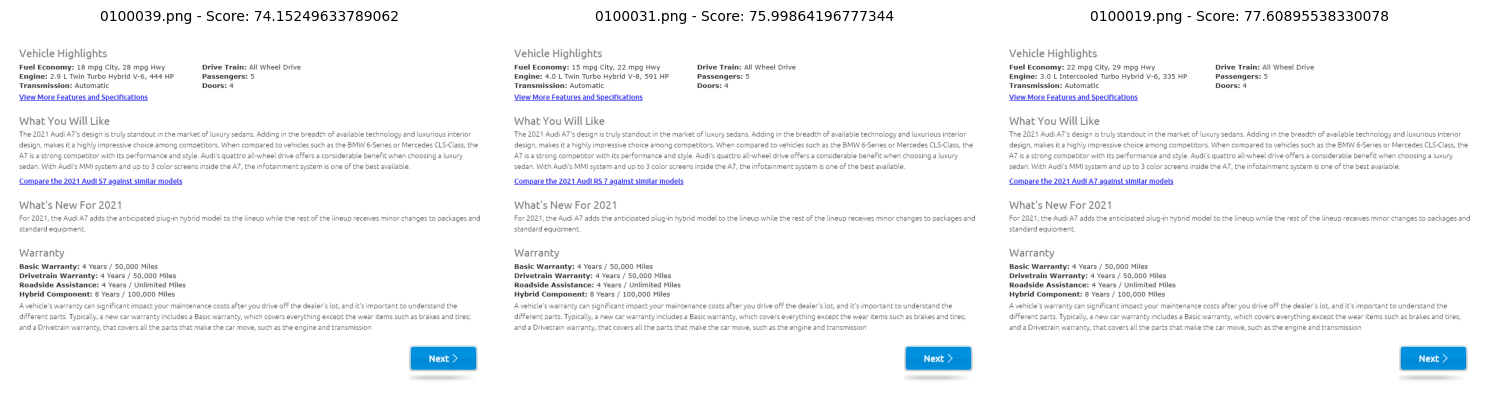

In [11]:
# 0100011
html_retrieval_by_query("Anything new in 2020 for 'Audi A4'") 

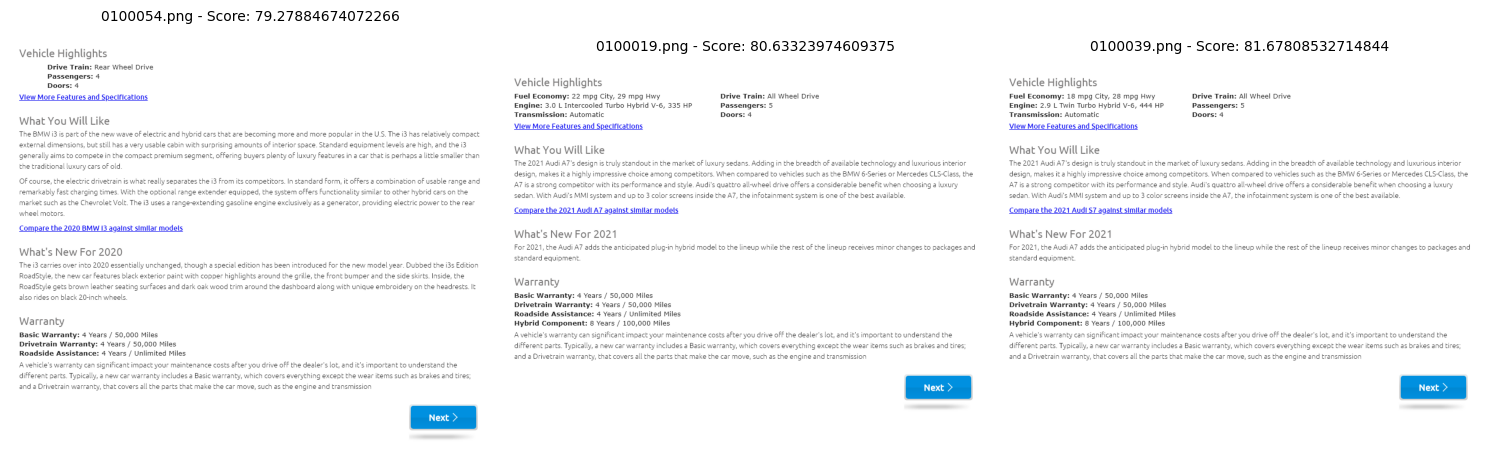

In [12]:
# 1000039
html_retrieval_by_query("The engine of '2012 Mercedes-Benz M-Class'")

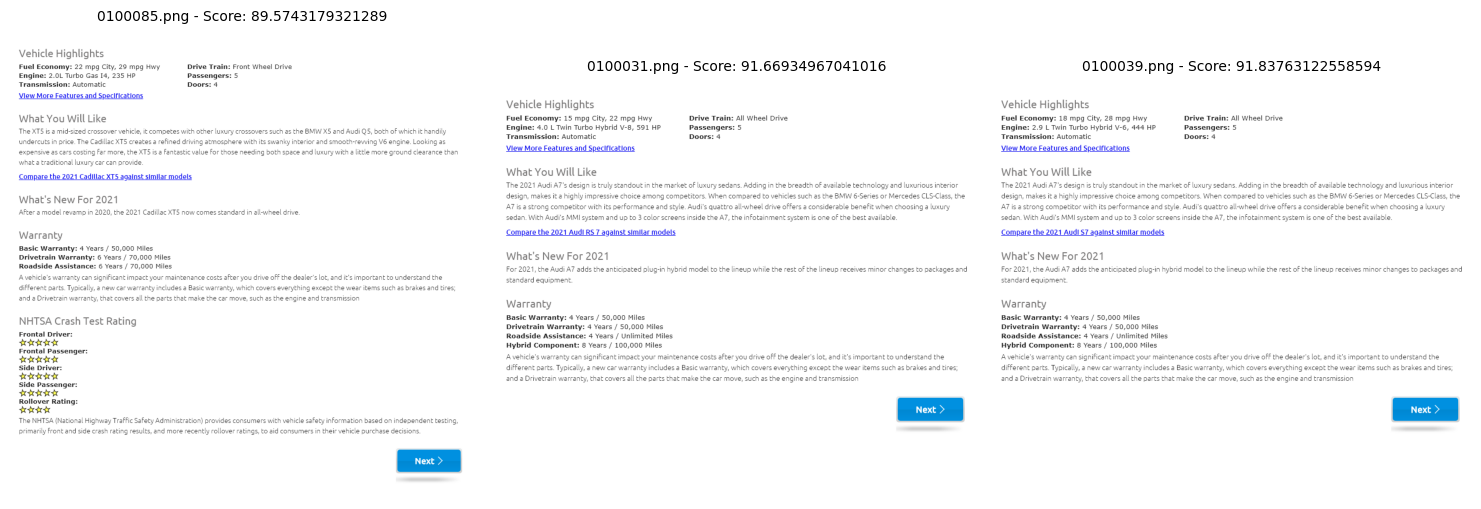

In [13]:
# 0900072
html_retrieval_by_query("Any information about 'Alfa Romeo Stelvio RWD'")

> More complex NL query

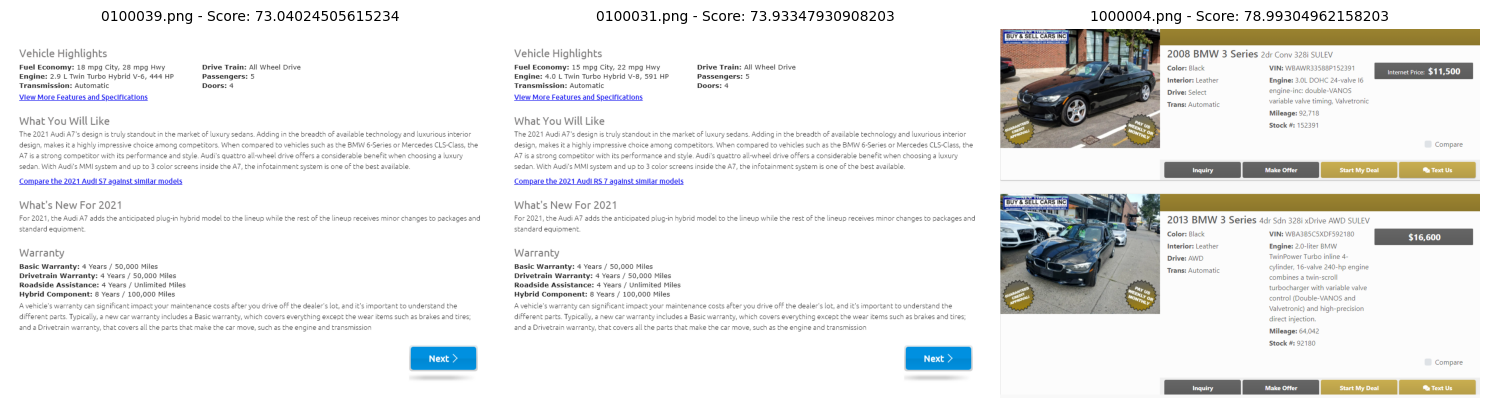

In [14]:
# 1000025
html_retrieval_by_query("For vehicle '2012 Infiniti M37, 4dr Sdn AWD', how much money I can save via online?")

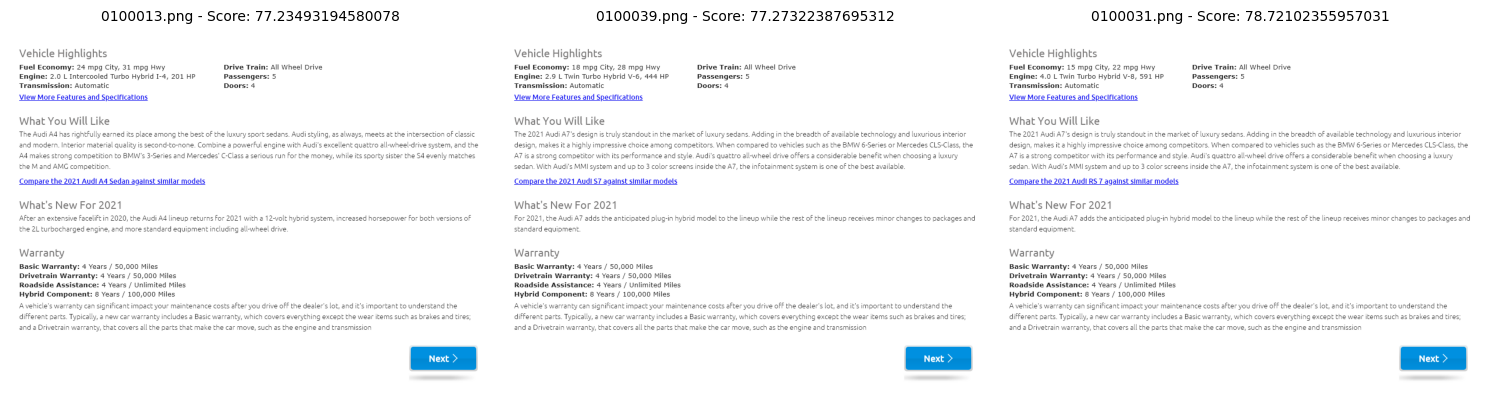

In [15]:
# 1100062
html_retrieval_by_query("What is the fuel consumption with the '5.7L V8 OHV 16-valve engine' and the 'Sport Utility' body type?")

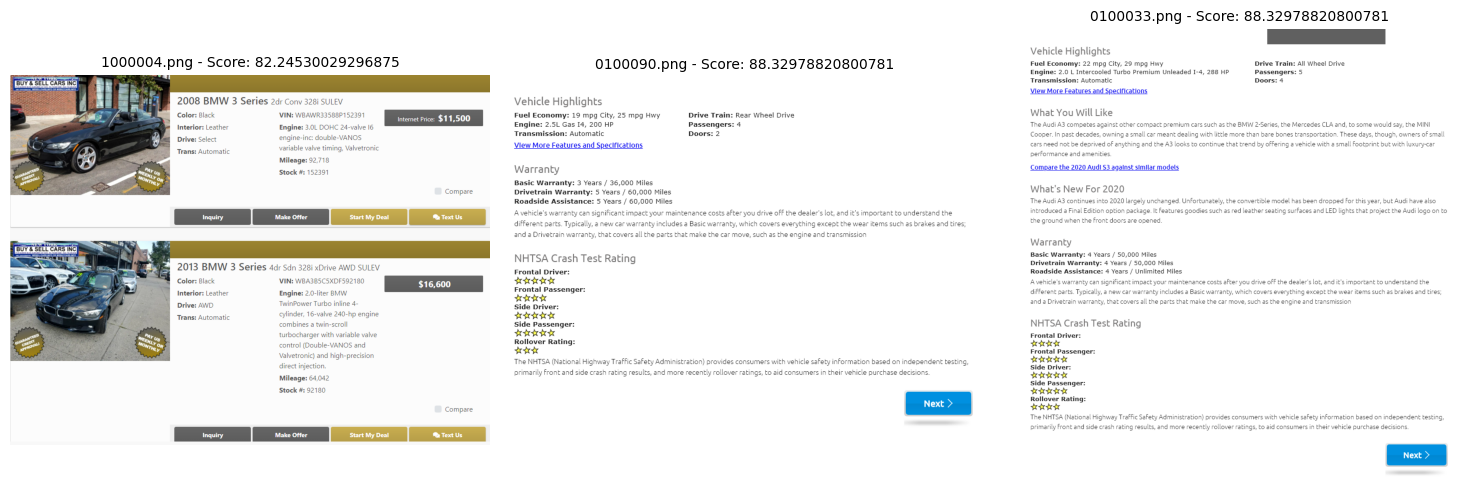

In [16]:
# 1200116
html_retrieval_by_query("A Nissan car with the price MSRP greater than or equal to 24,000")

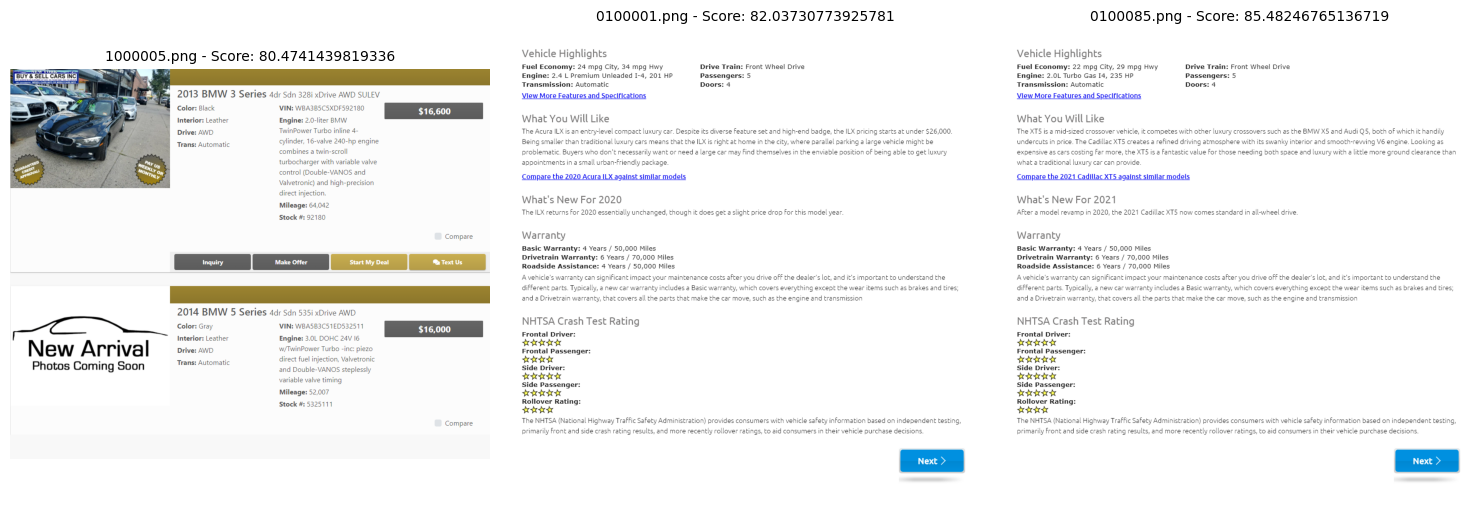

In [17]:
# 0300293
html_retrieval_by_query("Look for a car with a gross weight of 4,409 lbs. and a vehicle length of 171.4 \"") 

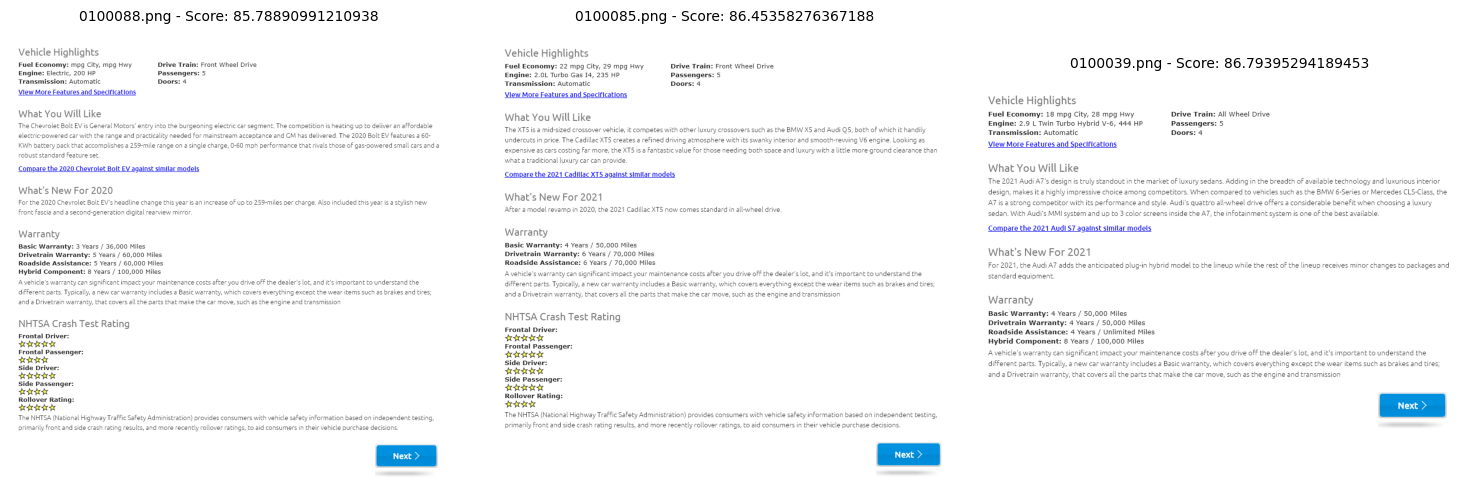

In [18]:
# 1200003
html_retrieval_by_query("For 'Jeep Cherokee' and 'Lincoln MKC', which one has higher fuel consumption?")

## DPR Document-level Top-N Result
| Query |   Top-1   |   Top-2   |   Top-3   |
|:-------------:|:---------:|:---------:|:---------:|
| How is the engine performance of the '2018 Maserati Ghibli'? |    ❌     |     ❌     |    ❌    |
| The price MSRP of 'Kia Sportage' |     ❌     |     ❌     |    ❌    |
| Anything new in 2021 for 'Audi A4' |    ❌     |     ❌     |    ❌    |
| The engine of '2012 Mercedes-Benz M-Class' |    ❌     |     ❌     |    ❌    |
| Any information about 'Alfa Romeo Stelvio RWD' |    ❌     |     ❌     |    ❌    |


| (More complex) Query |   Top-1   |   Top-2   |   Top-3   |
|:-------------:|:---------:|:---------:|:---------:|
| For vehicle '2012 Infiniti M37, 4dr Sdn AWD', how much money I can save via online? |    ❌     |     ❌     |    ❌    |
| What is the fuel consumption with the '5.7L V8 OHV 16-valve engine' and the 'Sport Utility' body type? |    ❌     |     ❌     |    ❌    |
| A Nissan car with price MSRP greater than or equal to 24,000  |    ❌     |     ❌     |    ❌    |
| Look for a car with a gross weight of 4,409 lbs. and a vehicle length of 171.4 \" |    ❌     |     ❌     |    ❌    |
| For 'Jeep Cherokee' and 'Lincoln MKC', which one has higher fuel consumption? |  ❌     |    ❌     |     ❌     |
